In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay-travel cluster classification in 1D: homebrew

## ToDos

* check that the newly split clusters are 
    * $\checkmark$ ~~contain enough samples~~
    * $\checkmark$  ~~have a total duration longer than the threshold~~
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller

## Current Meth

**Idea**: cluster events are collected in a bounding box (cylinder in 2D1T): properly centered, the B-box should stop collecting events if extended beyond a cluster.

1. Specify time-duration and location threshold
2. Get initial set of points
    * use index=0, and the highest index from the time increment
3. Get bouding box (circle) for set of points
4. Count the events in the box
5. Extend the box by the time increment and count again
6. if count increases, repeat; else, break and restart with new starting index

_Consider_: better to stop early and then stitch (if cluster centroids are within each other's boxes? $\to$ drifting!) rather than stop later. 

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

## Make the artificial data: 1D1T

**note** "T" here means just the index; later, it could be considered "time"

# Sythetic data

In [6]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.trajectory_class import get_trajectory

dsec = 1/3600.0
time = np.arange(0,24,dsec)
'''stays = [
        get_stay(  0.00,  6.40,-1.00), #home
        get_stay(  6.50, 17.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]'''

stays = [
        get_stay(  0,  6.40,  1),
        get_stay( 6.50,  18.0, -0.5),
        get_stay( 18.1,  19.5,  0.5),
        get_stay( 19.6,  20.9,  2.5),
        get_stay( 21.0, 24,  1)
    ]


configs = {
    'threshold':0.5,
    'event_frac':0.005,
    'duplicate_frac':0.3,    
    'noise_min':0.02,
    'noise_max':0.15
}


time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

In [7]:
noise_journey_sub.size

431

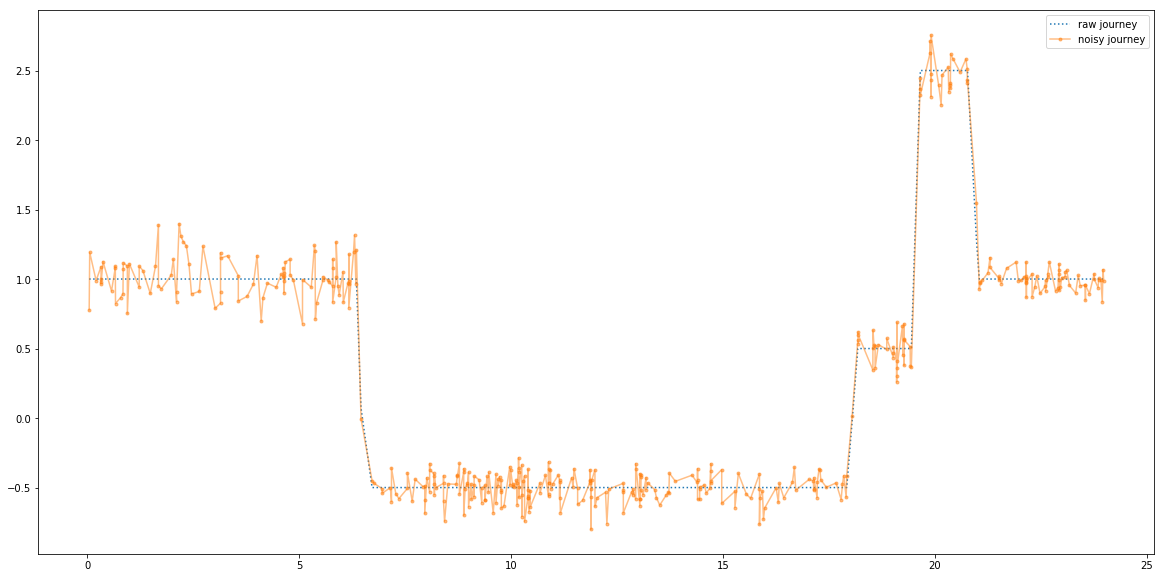

In [8]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();
#plt.xlim([6.2,6.6]);

# Clustering

## Get intial clusters

## Split the clusters which have a temporal gap

In [9]:
time_thresh = 1/12.
eps=0.25

In [11]:
get_err = lambda x1, x2: np.sqrt((x1-x2)**2) 

In [12]:
get_box_bounds = lambda sub_arr, eps: (np.mean(sub_arr), np.mean(sub_arr)+eps, np.mean(sub_arr)-eps)

In [13]:
def get_boxed_cluster(time_ind_0, time_ind, time_arr, loc_arr, eps, time_thresh, verbose=False):

    # Set the (initial) metrics for the 'box' -- could update along the way
    _, upper, lower = get_box_bounds(loc_arr[time_ind_0:time_ind], eps)
    
    # Set the sizes: exit once size does not change from last_size
    last_size = 0
    curr_size = 1
    
    escape = True
    while escape:

        # Advance the box in time; get the greatest timepoint in this region
        new_time = time_arr[time_ind]+time_thresh
        latest_time_ind = np.where(time_arr<=new_time)[0].max()
        
        # Using a sub-array, count all events within the 'box'
        subarr = loc_arr[time_ind_0:latest_time_ind]
        event_inds = np.where((subarr <= upper) & (subarr >= lower))[0]
        curr_size = event_inds.size

        # Report
        if verbose: print(last_size, '\t', curr_size,  '\t', latest_time_ind)

        # Check if the current size equals the last_size, and break
        if last_size == curr_size:
            break
        else:
            last_size = curr_size

        # This was added in the updated version; else, stick with the initial measures
        _, upper, lower = get_box_bounds(loc_arr[time_ind_0:time_ind], eps)
    
        # Update the time index
        time_ind = latest_time_ind

    return time_ind

In [14]:
from matplotlib.ticker import MultipleLocator

0 20 20 True 1.18 0.083
20 43 43 True 1.918 0.083
43 64 64 True 1.642 0.083
64 85 85 True 1.168 0.083
85 105 105 True 1.312 0.083
105 126 126 True 0.877 0.083
126 153 153 True 0.957 0.083
153 192 192 True 0.979 0.083
192 212 212 True 1.011 0.083
212 233 233 True 1.165 0.083
233 253 253 True 0.78 0.083
253 273 273 True 1.203 0.083
273 294 294 True 1.973 0.083
294 316 316 True 1.473 0.083
316 339 339 True 1.077 0.083
339 361 361 True 1.098 0.083
361 382 382 True 1.544 0.083
382 410 410 True 0.928 0.083
410 430 429 True 0.977 0.083


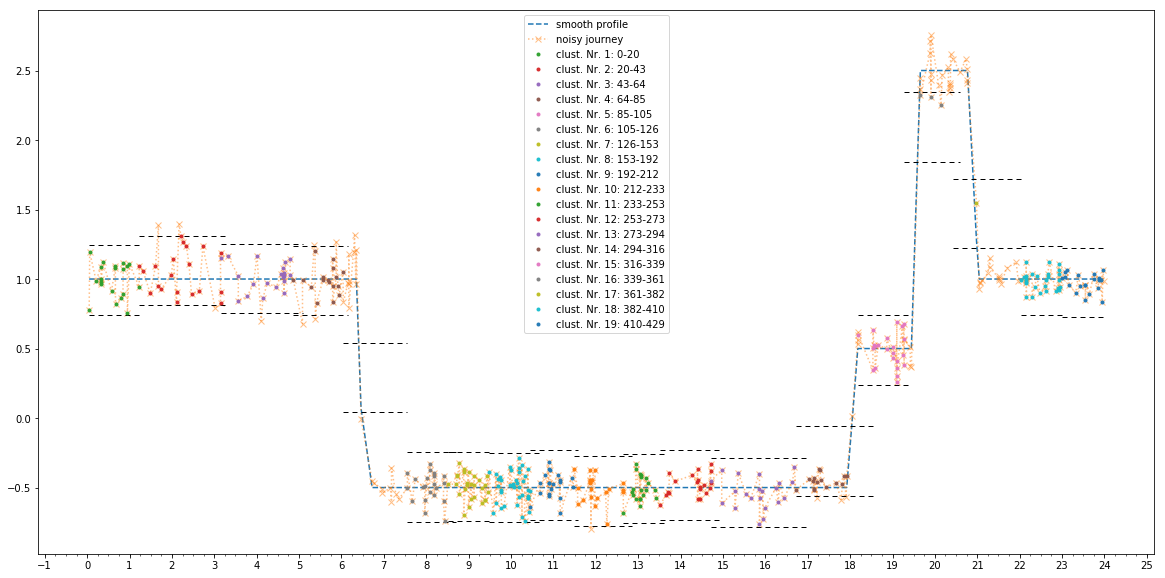

In [17]:
box_lines_dict = {'linestyle':'--','dashes':[5,4],'linewidth':1.0, 'color':'k'}


plt.figure(figsize=(20,10))

latest_time_ind = 0 #clusters[0][0]

plt.plot(time_sub, raw_journey_sub, '--', label='smooth profile')
plt.plot(time_sub, noise_journey_sub, 'x:', label='noisy journey', alpha=0.5)


epsi = eps/1.0
clust_nr = 1
while latest_time_ind+20 < len(time_sub):

    new_latest_time_ind = get_boxed_cluster(latest_time_ind,latest_time_ind+20,time_sub, noise_journey_sub, epsi, time_thresh)

    # 
    subarr =  noise_journey_sub[latest_time_ind:new_latest_time_ind]
    subarr_time = time_sub[latest_time_ind:new_latest_time_ind]
    _, upper, lower = get_box_bounds(subarr, epsi)

    lino = str(latest_time_ind)+' '+str(new_latest_time_ind)
    if new_latest_time_ind+1 >= len(time_sub): 
        new_latest_time_ind = len(time_sub)-2
    lino2 = str(new_latest_time_ind)
    
    plt.plot([time_sub[latest_time_ind],time_sub[new_latest_time_ind+1]], [upper,upper], **box_lines_dict)
    plt.plot([time_sub[latest_time_ind],time_sub[new_latest_time_ind+1]], [lower,lower], **box_lines_dict)

    event_inds = np.where((subarr <= upper) & (subarr >= lower))[0]
    
    plt.plot(subarr_time[event_inds], subarr[event_inds], '.', alpha=0.95, label=f'clust. Nr. {clust_nr}: {latest_time_ind}-{new_latest_time_ind}')
    
    
    time_diff = abs(subarr_time[-1]-subarr_time[0])
    
    latest_time_ind = new_latest_time_ind
    
    latest_time_ind < len(time_sub)
    print(lino,lino2,latest_time_ind < len(time_sub), round(time_diff,3), round(time_thresh,3))
    clust_nr += 1
    
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
'''
plt.xlim([1,3])
ax.xaxis.set_major_locator(MultipleLocator(0.1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.02))'''
#plt.xlim([5,10]);
#plt.xlim([18,22]);

plt.legend();

In [65]:
nr_stays = np.random.randint(10)

stay_time_bounds = np.concatenate((np.array([0]),24*np.random.random_sample(size=2*nr_stays),np.array([24])))

stay_time_bounds = np.sort(stay_time_bounds)

print(stay_time_bounds)

stay_xlocs = 4*np.random.random_sample(size=nr_stays+1) - 2.0

[ 0.          0.36192385  1.11089331  4.98417854  6.37632785  7.18908848
  8.43087968 13.17690117 16.28455561 18.01539354 19.05431615 24.        ]


In [67]:
stays = []
for n in range(nr_stays+1):
    
    nn = 2*n
    stay = get_stay(stay_time_bounds[nn], stay_time_bounds[nn+1],  stay_xlocs[n])
    print(n,nn,nn+1,stay)
    stays.append(stay)
    

0 0 1 {'type': 'stay', 'loc': -0.08907995051885509, 'start': 0.0, 'end': 0.36192385461628973, 'slope': 0}
1 2 3 {'type': 'stay', 'loc': 0.97111825323779, 'start': 1.110893308591832, 'end': 4.984178541287693, 'slope': 0}
2 4 5 {'type': 'stay', 'loc': -0.41841381335120653, 'start': 6.3763278472370075, 'end': 7.189088475866751, 'slope': 0}
3 6 7 {'type': 'stay', 'loc': -0.9303266844759417, 'start': 8.430879683654252, 'end': 13.176901170403807, 'slope': 0}
4 8 9 {'type': 'stay', 'loc': 0.4550935473734645, 'start': 16.284555605564314, 'end': 18.015393537681263, 'slope': 0}
5 10 11 {'type': 'stay', 'loc': 0.7487060166049271, 'start': 19.054316152371925, 'end': 24.0, 'slope': 0}


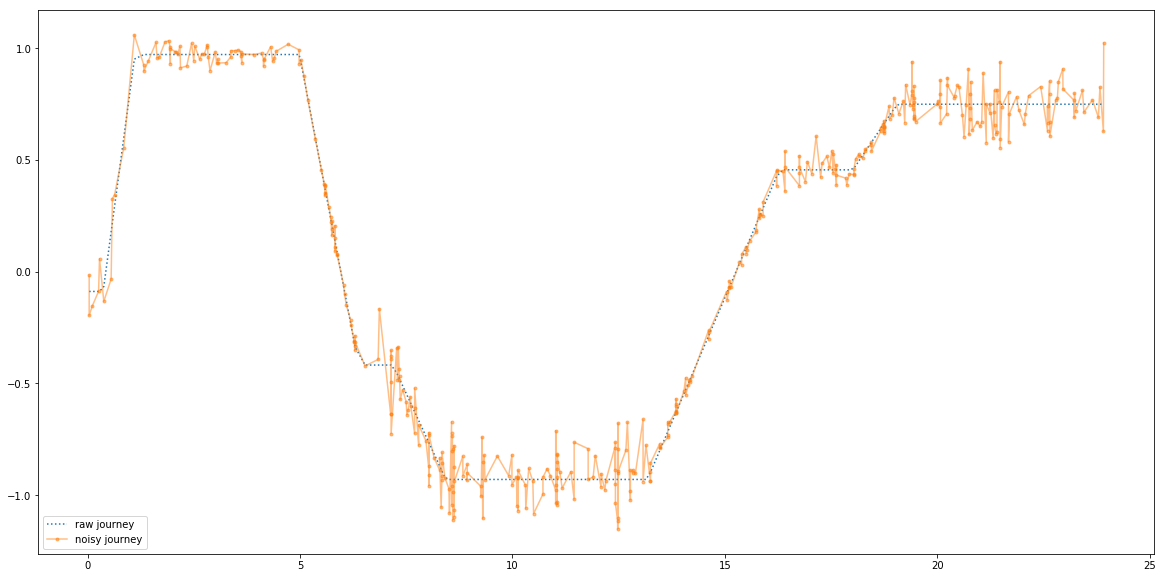

In [68]:
configs = {
    'threshold':0.5,
    'event_frac':0.005,
    'duplicate_frac':0.3,    
    'noise_min':0.02,
    'noise_max':0.15
}


time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();
#plt.xlim([6.2,6.6]);